In [68]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
plt.style.use('default')
from tqdm import tqdm
import glob
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress
import pickle as pkl

from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn import preprocessing

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
files = glob.glob('../BL_Work/openPrescribe/savings/*.gz')

In [15]:
%store -r psycho_equivalent_df

In [16]:
# ome = pd.read_csv('scratchpad/ome_rossano.csv')
ome = psycho_equivalent_df

In [18]:
ome['BNF_stub'] = ome['BNF']

In [19]:
ome.head()

,BNF,Name,equivalent_mg,BNF_stub
0,0402020AB,paliperidone,0.020,0402020AB
1,0402020AC,olanzapine embonate,0.050,0402020AC
2,0402020AA,risperidone,0.010,0402020AA
3,0402020AD,aripiprazole,0.075,0402020AD
4,0402010M0,loxapine succinate,0.100,0402010M0


In [20]:
with open('scratchpad/Bipartite_Drug_graph.pkl','rb') as f:
    drug_association_graph  = pkl.load(f)

with open('scratchpad/Bipartite_Drug_category_graph.pkl','rb') as f:
    drug_cat_association_graph  = pkl.load(f)

In [21]:
files = glob.glob('../BL_Work/openPrescribe/savings_Impact/*.h5')
files.sort()
print files

['../BL_Work/openPrescribe/savings_Impact/201406.h5', '../BL_Work/openPrescribe/savings_Impact/201407.h5', '../BL_Work/openPrescribe/savings_Impact/201408.h5', '../BL_Work/openPrescribe/savings_Impact/201409.h5', '../BL_Work/openPrescribe/savings_Impact/201410.h5', '../BL_Work/openPrescribe/savings_Impact/201411.h5', '../BL_Work/openPrescribe/savings_Impact/201412.h5', '../BL_Work/openPrescribe/savings_Impact/201501.h5', '../BL_Work/openPrescribe/savings_Impact/201502.h5', '../BL_Work/openPrescribe/savings_Impact/201503.h5', '../BL_Work/openPrescribe/savings_Impact/201504.h5', '../BL_Work/openPrescribe/savings_Impact/201505.h5', '../BL_Work/openPrescribe/savings_Impact/201506.h5', '../BL_Work/openPrescribe/savings_Impact/201507.h5', '../BL_Work/openPrescribe/savings_Impact/201508.h5', '../BL_Work/openPrescribe/savings_Impact/201509.h5', '../BL_Work/openPrescribe/savings_Impact/201510.h5', '../BL_Work/openPrescribe/savings_Impact/201511.h5', '../BL_Work/openPrescribe/savings_Impact/2015

In [22]:
files[19]

'../BL_Work/openPrescribe/savings_Impact/201601.h5'

In [10]:
pdp = pd.read_hdf(files[0])
pdp.dropna()
for file in files[0:0+3]:
    pdp2 = pd.read_hdf(file)
    pdp2.dropna()
    pdp.append(pdp2)

In [23]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 34712       43870  Q44  01R  N81016  0101010C0BBAAAA   
  47626       56784  Q44  01R  N81068  0101010C0BBAAAA   
  50737       59895  Q44  01R  N81084  0101010C0BBAAAA   
  55199       64357  Q44  01R  N81614  0101010C0AAAAAA   
  74259       83978  Q44  02D  N81127  0101010C0BBAAAA   

                                                4    5      6      7      8  \
0 34712  Alu-Cap_Cap 475mg                         1.0  27.42  25.34  240.0   
  47626  Alu-Cap_Cap 475mg                         1.0  41.13  38.00  360.0   
  50737  Alu-Cap_Cap 475mg                         1.0  54.84  50.66  480.0   
  55199  Alum Hydrox_Cap 475mg                     1.0  13.71  12.66  120.0   
  74259  Alu-Cap_Cap 475mg                         1.0  38.39  35.57  336.0   

                9       10         11   12           13                   14  \
0 34712  201406.0  CW1 3AW  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  47626  201406.0  CW1 3HB  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  50737  201406.0  CW2 5DA  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  55199  201406.0  CW5 8EW  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  74259  201406.0  CW7 1AT  0101010C0  NaN  indigestion  Aluminium Hydroxide   

            15         16    17   18    19  20     21        22   23        24  
0 34712  475.0  0101010C0  20.0  1.0  20.0  BB  0.115  0.110952  0.0  1.979167  
  47626  475.0  0101010C0  30.0  1.0  30.0  BB  0.115  0.110952  0.0  1.319444  
  50737  475.0  0101010C0  40.0  1.0  40.0  BB  0.115  0.110952  0.0  0.989583  
  55199  475.0  0101010C0  10.0  1.0  10.0  AA  0.115  0.110952  0.0  3.958333  
  74259  475.0  0101010C0  28.0  1.0  28.0  BB  0.115  0.110952  0.0  1.413690

In [24]:
len(pdp)

8932165

In [25]:
# bnf_ome_map_df = {'BNF' : [] , 'OME':[] , 'BNF_variants' : []}
# for name , group in ome.groupby('BNF_stub'):
#     bnf_ome_map_df['BNF'].append(name)
#     bnf_ome_map_df['BNF_variants'].append(set(group['bnf_name']))
#     bnf_ome_map_df['OME'].append(list(set(group['ome_multiplier']))[0])
# bnf_ome_map_df = pd.DataFrame.from_dict(bnf_ome_map_df)

In [26]:
# bnf_ome_map = {}
# for name , group in ome.groupby('BNF_stub'):
# #     if list(set(group['ome_multiplier']))[0] < 0:
#     bnf_ome_map[name] = list(set(group['ome_multiplier']))[0]

In [27]:
# bnf_ome_map_df.head()

In [28]:
# bnf_ome_map = {}
# for index, row in bnf_ome_map_df.iterrows():
#     bnf_ome_map[row['BNF']] = row['OME']

In [29]:
#  bnf_ome_map_df[bnf_ome_map_df['OME'] < 10]

In [30]:
pdp['25'] = pdp['3'].apply(lambda x : x[:-2])

In [31]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 34712       43870  Q44  01R  N81016  0101010C0BBAAAA   
  47626       56784  Q44  01R  N81068  0101010C0BBAAAA   
  50737       59895  Q44  01R  N81084  0101010C0BBAAAA   
  55199       64357  Q44  01R  N81614  0101010C0AAAAAA   
  74259       83978  Q44  02D  N81127  0101010C0BBAAAA   

                                                4    5      6      7      8  \
0 34712  Alu-Cap_Cap 475mg                         1.0  27.42  25.34  240.0   
  47626  Alu-Cap_Cap 475mg                         1.0  41.13  38.00  360.0   
  50737  Alu-Cap_Cap 475mg                         1.0  54.84  50.66  480.0   
  55199  Alum Hydrox_Cap 475mg                     1.0  13.71  12.66  120.0   
  74259  Alu-Cap_Cap 475mg                         1.0  38.39  35.57  336.0   

                9       10         11   12           13                   14  \
0 34712  201406.0  CW1 3AW  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  47626  201406.0  CW1 3HB  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  50737  201406.0  CW2 5DA  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  55199  201406.0  CW5 8EW  0101010C0  NaN  indigestion  Aluminium Hydroxide   
  74259  201406.0  CW7 1AT  0101010C0  NaN  indigestion  Aluminium Hydroxide   

            15         16    17   18    19  20     21        22   23  \
0 34712  475.0  0101010C0  20.0  1.0  20.0  BB  0.115  0.110952  0.0   
  47626  475.0  0101010C0  30.0  1.0  30.0  BB  0.115  0.110952  0.0   
  50737  475.0  0101010C0  40.0  1.0  40.0  BB  0.115  0.110952  0.0   
  55199  475.0  0101010C0  10.0  1.0  10.0  AA  0.115  0.110952  0.0   
  74259  475.0  0101010C0  28.0  1.0  28.0  BB  0.115  0.110952  0.0   

               24             25  
0 34712  1.979167  0101010C0BBAA  
  47626  1.319444  0101010C0BBAA  
  50737  0.989583  0101010C0BBAA  
  55199  3.958333  0101010C0AAAA  
  74259  1.413690  0101010C0BBAA

In [32]:
opioids_ome = pdp[pdp['16'].isin(ome['BNF_stub'])]

In [33]:
opioids_ome = opioids_ome[opioids_ome['15']>0]

In [34]:
opioids_ome.size

1372356

In [35]:
opioids_ome['mcg_potency'] = opioids_ome['15']*1000.0 

In [36]:
opioids_ome.head(n=100)

Unnamed: 0    0    1       2                3  \
389 465          2245  Q44  01C  N81002  0402010ABAAABAB   
    466          2246  Q44  01C  N81002  0402010ABAAACAC   
    467          2247  Q44  01C  N81002  0402010ABAAADAD   
    468          2248  Q44  01C  N81002  0402010ABAAAFAF   
    469          2249  Q44  01C  N81002  0402010ABAAAKAK   
    2050         3830  Q44  01C  N81013  0402010ABAAABAB   
    2051         3831  Q44  01C  N81013  0402010ABAAACAC   
    2052         3832  Q44  01C  N81013  0402010ABAAADAD   
    2053         3833  Q44  01C  N81013  0402010ABAAAFAF   
    2054         3834  Q44  01C  N81013  0402010ABAAAKAK   
    2055         3835  Q44  01C  N81013  0402010ABAAAXAX   
    2056         3836  Q44  01C  N81013  0402010ABAABABA   
    3558         6790  Q44  01C  N81022  0402010ABAAABAB   
    3559         6791  Q44  01C  N81022  0402010ABAAACAC   
    3560         6792  Q44  01C  N81022  0402010ABAAADAD   
    3561         6793  Q44  01C  N81022  0402010ABAAAFAF   
    3562         6794  Q44  01C  N81022  0402010ABAAAKAK   
    3563         6795  Q44  01C  N81022  0402010ABAAAVAV   
    3564         6796  Q44  01C  N81022  0402010ABAAAWAW   
    3565         6797  Q44  01C  N81022  0402010ABAAAXAX   
    5203         8435  Q44  01C  N81026  0402010ABAAABAB   
    5204         8436  Q44  01C  N81026  0402010ABAAACAC   
    5205         8437  Q44  01C  N81026  0402010ABAAADAD   
    5206         8438  Q44  01C  N81026  0402010ABAAAKAK   
    6949        10181  Q44  01C  N81027  0402010ABAAABAB   
    6950        10182  Q44  01C  N81027  0402010ABAAACAC   
    6951        10183  Q44  01C  N81027  0402010ABAAADAD   
    6952        10184  Q44  01C  N81027  0402010ABAAAFAF   
    6953        10185  Q44  01C  N81027  0402010ABAAAKAK   
    6954        10186  Q44  01C  N81027  0402010ABAAAVAV   
...               ...  ...  ...     ...              ...   
    14924       18156  Q44  01C  N81052  0402010ABAABABA   
    16670       19902  Q44  01C  N81062  0402010ABAAABAB   
    16671       19903  Q44  01C  N81062  0402010ABAAACAC   
    16672       19904  Q44  01C  N81062  0402010ABAAADAD   
    16673       19905  Q44  01C  N81062  0402010ABAAAKAK   
    16674       19906  Q44  01C  N81062  0402010ABAAAXAX   
    16675       19907  Q44  01C  N81062  0402010ABBBADAD   
    16676       19908  Q44  01C  N81062  0402010ABBBAGAK   
    18483       21715  Q44  01C  N81069  0402010ABAAABAB   
    18484       21716  Q44  01C  N81069  0402010ABAAACAC   
    19679       22911  Q44  01C  N81070  0402010ABAAABAB   
    19680       22912  Q44  01C  N81070  0402010ABAAACAC   
    19681       22913  Q44  01C  N81070  0402010ABAAADAD   
    19682       22914  Q44  01C  N81070  0402010ABAAAFAF   
    19683       22915  Q44  01C  N81070  0402010ABAAAKAK   
    19684       22916  Q44  01C  N81070  0402010ABBBAJAX   
    21497       26524  Q44  01C  N81077  0402010ABAAABAB   
    21498       26525  Q44  01C  N81077  0402010ABAAACAC   
    21499       26526  Q44  01C  N81077  0402010ABAAADAD   
    21500       26527  Q44  01C  N81077  0402010ABAAAFAF   
    21501       26528  Q44  01C  N81077  0402010ABAAAXAX   
    21502       26529  Q44  01C  N81077  0402010ABBCAAAV   
    21503       26530  Q44  01C  N81077  0402010ABBCABAW   
    21504       26531  Q44  01C  N81077  0402010ABBCACAX   
    21505       26532  Q44  01C  N81077  0402010ABBCAEBA   
    23295       28322  Q44  01C  N81085  0402010ABAAABAB   
    23296       28323  Q44  01C  N81085  0402010ABAAACAC   
    23297       28324  Q44  01C  N81085  0402010ABAAAKAK   
    23298       28325  Q44  01C  N81085  0402010ABAAAVAV   
    23299       28326  Q44  01C  N81085  0402010ABAAAWAW   

                                                  4     5       6       7  \
389 465    Quetiapine_Tab 25mg                        1.0    2.69    2.60   
    466    Quetiapine_Tab 100mg                       2.0    2.26    2.32   
    467    Quetiapine_Tab 200mg                       2.0  

In [39]:
bnf_ome_map = {}
for index , row in ome.iterrows():
    bnf_ome_map[row['BNF']] = row['equivalent_mg']

In [40]:
def func_ome(df,drugBNF,ome_map):
    df['26'] = df['8'] *df['mcg_potency']*ome_map[drugBNF]
    df['27'] =  ome_map[drugBNF]
    df['28'] = df['8'] * df['mcg_potency']
    return df
    

def calculateOME(pdp,ome_map):
    pdp['26'] = 0.0
    return pdp.groupby('16',as_index=False).apply(lambda df: func_ome(df , df.name, ome_map ))

ome_df = calculateOME(opioids_ome , bnf_ome_map)

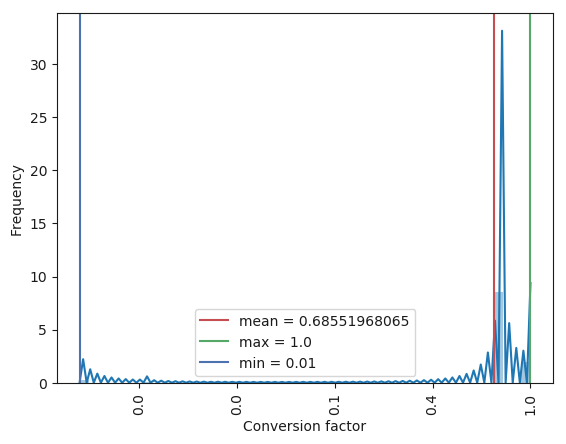

In [69]:
sns.distplot(np.log(ome_df['27']))

mean_val = np.mean(np.log(ome_df['27']))
max_val = np.max(np.log(ome_df['27']))
min_val = np.min(np.log(ome_df['27']))
plt.axvline(x=mean_val,label='mean = {}'.format(np.exp(mean_val)) , c = 'r')
plt.axvline(x=max_val,label='max = {}'.format(np.exp(max_val)), c = 'g')
plt.axvline(x=min_val,label='min = {}'.format(np.exp(min_val)), c = 'b')
ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.xticks(rotation=90)

plt.xlabel('Conversion factor')
plt.ylabel('Frequency')

plt.legend()
plt.show()

In [73]:
min(ome_df['27']) , max(ome_df['27']) , np.mean(ome_df['27'])

(0.01, 1.0, 0.7696374045801693)

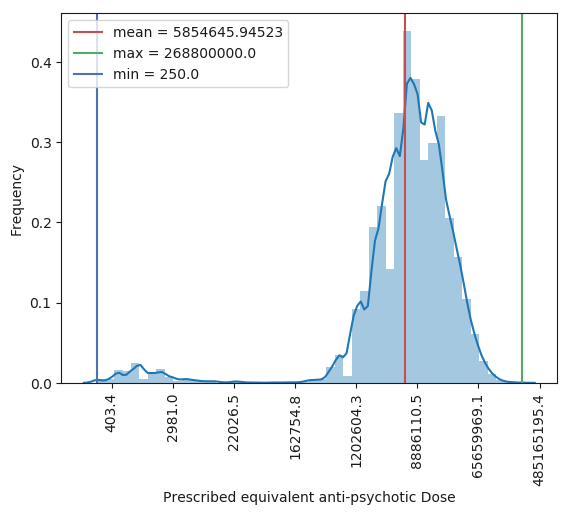

In [81]:
sns.distplot(np.log(ome_df['26']))

mean_val = np.mean(np.log(ome_df['26']))
max_val = np.max(np.log(ome_df['26']))
min_val = np.min(np.log(ome_df['26']))
plt.axvline(x=mean_val,label='mean = {}'.format(np.exp(mean_val)) , c = 'r')
plt.axvline(x=max_val,label='max = {}'.format(np.exp(max_val)), c = 'g')
plt.axvline(x=min_val,label='min = {}'.format(np.exp(min_val)), c = 'b')

ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.xticks(rotation=90)

plt.xlabel('Prescribed equivalent anti-psychotic Dose')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [44]:
min(ome_df['26']) , max(ome_df['26']) , np.mean(ome_df['26'])

(250.0, 268800000.0, 12654800.479066657)

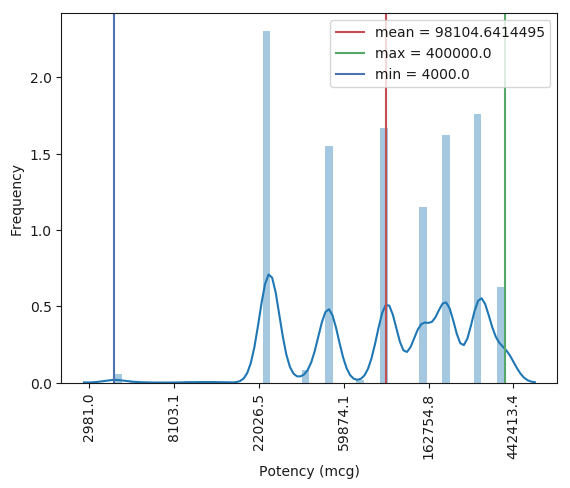

In [78]:
sns.distplot(np.log(ome_df['mcg_potency']))

mean_val = np.mean(np.log(ome_df['mcg_potency']))
max_val = np.max(np.log(ome_df['mcg_potency']))
min_val = np.min(np.log(ome_df['mcg_potency']))
plt.axvline(x=mean_val,label='mean = {}'.format(np.exp(mean_val)) , c = 'r')
plt.axvline(x=max_val,label='max = {}'.format(np.exp(max_val)), c = 'g')
plt.axvline(x=min_val,label='min = {}'.format(np.exp(min_val)), c = 'b')

ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.xticks(rotation=90)

plt.xlabel('Potency (mcg)')
plt.ylabel('Frequency')

plt.legend()
plt.show()

In [79]:
min(ome_df['15']) , max(ome_df['15']) , np.mean(ome_df['15'])

(4.0, 400.0, 145.64667112615095)

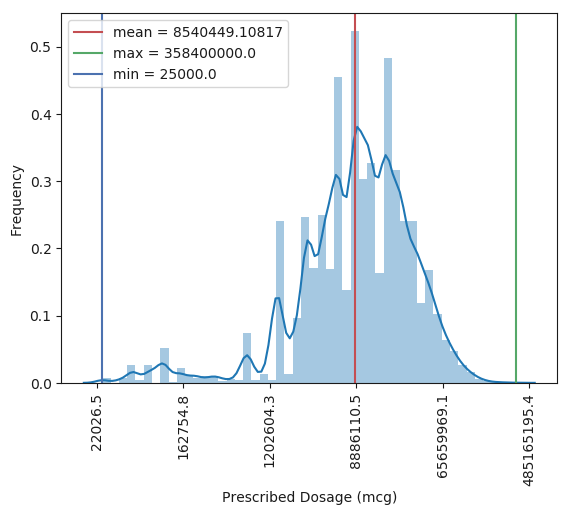

In [82]:
sns.distplot(np.log(ome_df['28']))

mean_val = np.mean(np.log(ome_df['28']))
max_val = np.max(np.log(ome_df['28']))
min_val = np.min(np.log(ome_df['28']))
plt.axvline(x=mean_val,label='mean = {}'.format(np.exp(mean_val)) , c = 'r')
plt.axvline(x=max_val,label='max = {}'.format(np.exp(max_val)), c = 'g')
plt.axvline(x=min_val,label='min = {}'.format(np.exp(min_val)), c = 'b')

ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.xticks(rotation=90)

plt.xlabel('Prescribed Dosage (mcg)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [48]:
min(ome_df['28']) , max(ome_df['28']) , np.mean(ome_df['28'])

(25000.0, 358400000.0, 16432068.053041631)

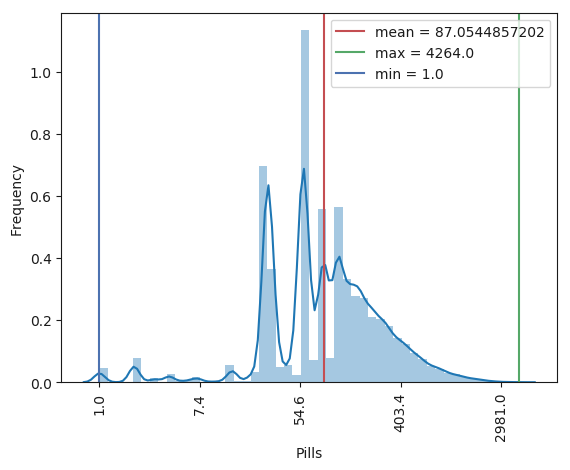

In [83]:
sns.distplot(np.log(ome_df['8']))

mean_val = np.mean(np.log(ome_df['8']))
max_val = np.max(np.log(ome_df['8']))
min_val = np.min(np.log(ome_df['8']))
plt.axvline(x=mean_val,label='mean = {}'.format(np.exp(mean_val)) , c = 'r')
plt.axvline(x=max_val,label='max = {}'.format(np.exp(max_val)), c = 'g')
plt.axvline(x=min_val,label='min = {}'.format(np.exp(min_val)), c = 'b')
ax = plt.gca()
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.xticks(rotation=90)

plt.xlabel('Pills')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [84]:
min(ome_df['8']) , max(ome_df['8']) , np.mean(ome_df['8'])

(1.0, 4264.0, 160.08396946564886)

In [85]:
ome_df[ome_df['8'] > 72000]

,,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,mcg_potency,26,27,28,ln_potency,ln_pills,ln_dosage,potency_rank,pills_rank,dosage_rank,ln_ome,potency_quantile,pills_quantile,dosage_quantile


In [86]:
ome_df['ln_potency'] = np.log(ome_df['mcg_potency'])
ome_df['ln_pills'] = np.log(ome_df['8'])
ome_df['ln_dosage'] = np.log(ome_df['28'])
ome_df['potency_rank'] = ome_df['ln_potency'].rank(method='first')
ome_df['pills_rank'] = ome_df['ln_pills'].rank(method='first')
ome_df['dosage_rank'] = ome_df['ln_dosage'].rank(method='first')

In [87]:
ome_df['ln_ome'] = np.log(ome_df['27'])

In [88]:
ome_df['potency_quantile'] = pd.qcut(ome_df['potency_rank'],50 ,labels=np.arange(1,51,1))
ome_df['pills_quantile'] = pd.qcut(ome_df['pills_rank'],50, labels=np.arange(1,51,1))
ome_df['dosage_quantile'] = pd.qcut(ome_df['dosage_rank'],50, labels=np.arange(1,51,1))

In [89]:
ome_df.head()

Unnamed: 0    0    1       2                3  \
389 465        2245  Q44  01C  N81002  0402010ABAAABAB   
    466        2246  Q44  01C  N81002  0402010ABAAACAC   
    467        2247  Q44  01C  N81002  0402010ABAAADAD   
    468        2248  Q44  01C  N81002  0402010ABAAAFAF   
    469        2249  Q44  01C  N81002  0402010ABAAAKAK   

                                                4    5      6      7      8  \
389 465  Quetiapine_Tab 25mg                       1.0   2.69   2.60  112.0   
    466  Quetiapine_Tab 100mg                      2.0   2.26   2.32   56.0   
    467  Quetiapine_Tab 200mg                      2.0  14.67  13.68  270.0   
    468  Quetiapine_Tab 150mg                      3.0   5.38   5.21  116.0   
    469  Quetiapine_Tab 300mg                      3.0  10.42   9.86  144.0   

                9       10         11       12       13          14     15  \
389 465  201406.0  SK9 1PA  0402010AB  bipolar  anxiety  Quetiapine   25.0   
    466  201406.0  SK9 1PA  0402010AB  bipolar  anxiety  Quetiapine  100.0   
    467  201406.0  SK9 1PA  0402010AB  bipolar  anxiety  Quetiapine  200.0   
    468  201406.0  SK9 1PA  0402010AB  bipolar  anxiety  Quetiapine  150.0   
    469  201406.0  SK9 1PA  0402010AB  bipolar  anxiety  Quetiapine  300.0   

                16     17    18      19  20        21        22          23  \
389 465  0402010AB  112.0   2.0   224.0  AA  0.080000  0.631429   61.760000   
    466  0402010AB   56.0   8.0   448.0  AA  0.150000  1.757143   90.000000   
    467  0402010AB  270.0  16.0  4320.0  AA  0.160000  1.795000  441.450000   
    468  0402010AB  116.0  12.0  1392.0  AA  0.043333  1.662143  187.781905   
    469  0402010AB  144.0  24.0  3456.0  AA  0.120000  2.632857  361.851429   

               24             25  mcg_potency          26    27          28  \
389 465  0.223214  0402010ABAAAB      25000.0   2100000.0  0.75   2800000.0   
    466  1.785714  0402010ABAAAC     100000.0   4200000.0  0.75   5600000.0   
    467  0.740741  0402010ABAAAD     200000.0  40500000.0  0.75  54000000.0   
    468  1.293103  0402010ABAAAF     150000.0  13050000.0  0.75  17400000.0   
    469  2.083333  0402010ABAAAK     300000.0  32400000.0  0.75  43200000.0   

         ln_potency  ln_pills  ln_dosage  potency_rank  pills_rank  \
389 465   10.126631  4.718499  14.845130         386.0     28201.0   
    466   11.512925  4.025352  15.538277       18883.0     12522.0   
    467   12.206073  5.598422  17.804495       32072.0     43122.0   
    468   11.918391  4.753590  16.671981       26691.0     30249.0   
    469   12.611538  4.969813  17.581351       39669.0     34319.0   

         dosage_rank    ln_ome potency_quantile pills_quantile dosage_quantile  
389 465       6386.0 -0.287682                1             28               7  
    466      14462.0 -0.287682               19             13              15  
    467      48319.0 -0.287682               32             43              48  
    468      34709.0 -0.287682               27             30              35  
    469      46510.0 -0.287682               40             34              46

In [90]:
binned_mean_OME_potency = {}
binned_mean_OME_pills = {}
binned_mean_OME_dosage = {}

binned_mean_potency_pills = {}
binned_var_potency_pills = {}

binpotency_val = {}
binpills_val = {}
bindosage_val = {}

binned_var_OME_pills = {}
binned_var_OME_potency = {}
binned_var_OME_dosage = {}

for name , group in ome_df.groupby('potency_quantile'):
    binned_mean_OME_potency[name] = np.mean(np.log(group['27']))
    binned_var_OME_potency[name] = np.var(np.log(group['27']))/np.sqrt(len(group))

    binned_mean_potency_pills[name] = np.mean(group['ln_pills'])
    binned_var_potency_pills[name] = np.var(group['ln_pills'])/np.sqrt(len(group))
    
    binpotency_val[name] = np.mean(group['ln_potency'])
    

for name , group in ome_df.groupby('pills_quantile'):
    binned_mean_OME_pills[name] = np.mean(np.log(group['27']))
    binpills_val[name] = np.mean(group['ln_pills'])
    binned_var_OME_pills[name] = np.var(np.log(group['27']))/np.sqrt(len(group))

for name , group in ome_df.groupby('dosage_quantile'):
    binned_mean_OME_dosage[name] = np.mean(np.log(group['27']))
    bindosage_val[name] = np.mean(group['ln_dosage'])
    binned_var_OME_dosage[name] = np.var(np.log(group['27']))/np.sqrt(len(group))

In [91]:
def goodNessFit(realVal, fitVal):
    # residual sum of squares
    ss_res = np.sum((realVal - fitVal) ** 2)

    # total sum of squares
    ss_tot = np.sum((realVal - np.mean(realVal)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    print(r2)
    return r2

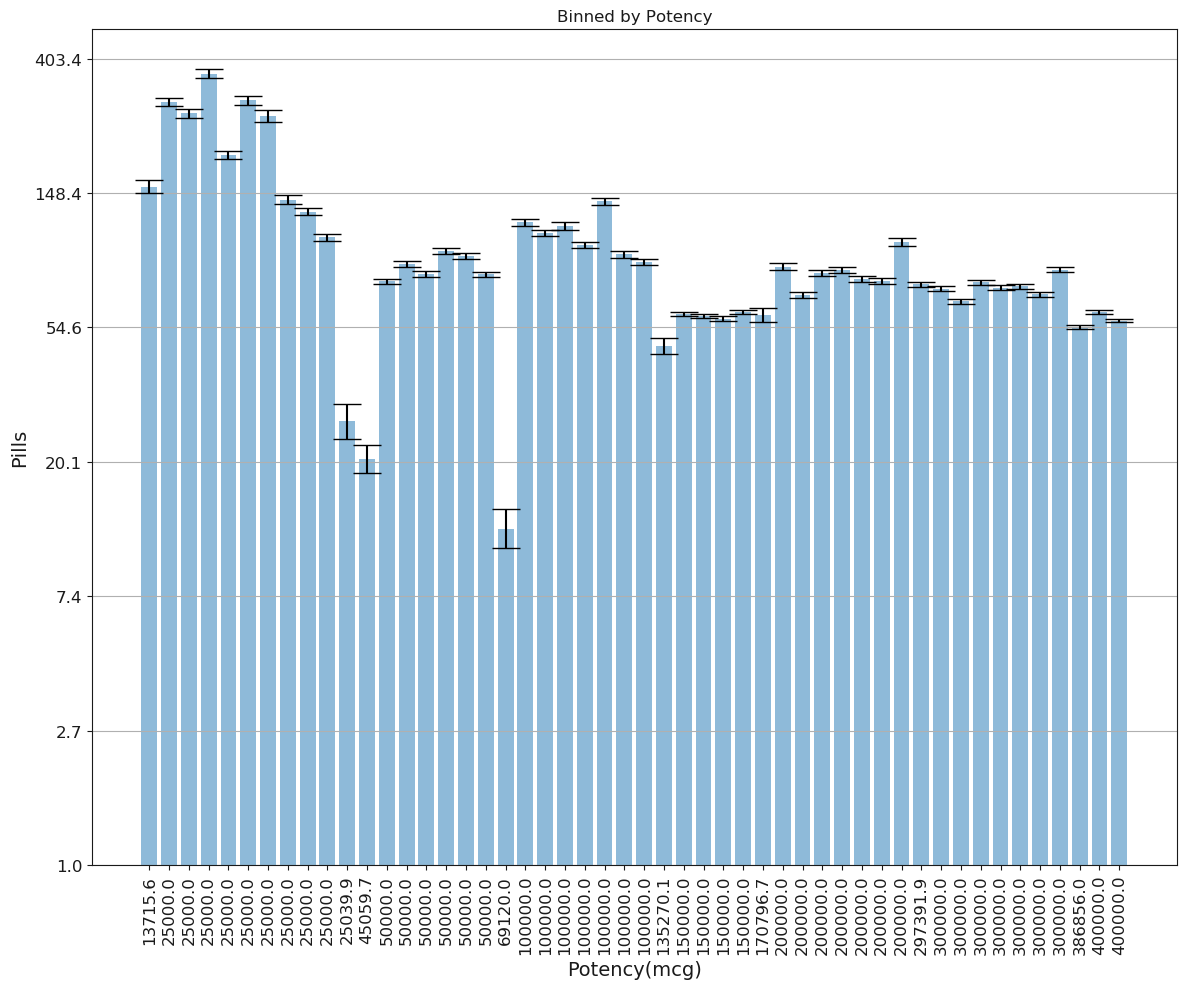

In [92]:
fig, ax = plt.subplots(figsize=(12,10))
x_pos = np.arange(1,51,1)

x_labels = ['{:0.1f}'.format(np.exp(binpotency_val[k])) for k in x_pos]

y_val = [binned_mean_potency_pills[k] for k in x_pos]
err = [binned_var_potency_pills[k] for k in x_pos]
ax.bar(x_pos, y_val, yerr=err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Pills' , fontsize = 14)
ax.set_xlabel('Potency(mcg)',fontsize = 14)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation='90' , fontsize = 12)
ax.set_title('Binned by Potency')
ax.yaxis.grid(True)


ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


# Save the figure and show
plt.tight_layout()
plt.show()

[-2.13348318e+05  3.46654573e+00  1.00000000e+00]
1.4566392536607964e-10


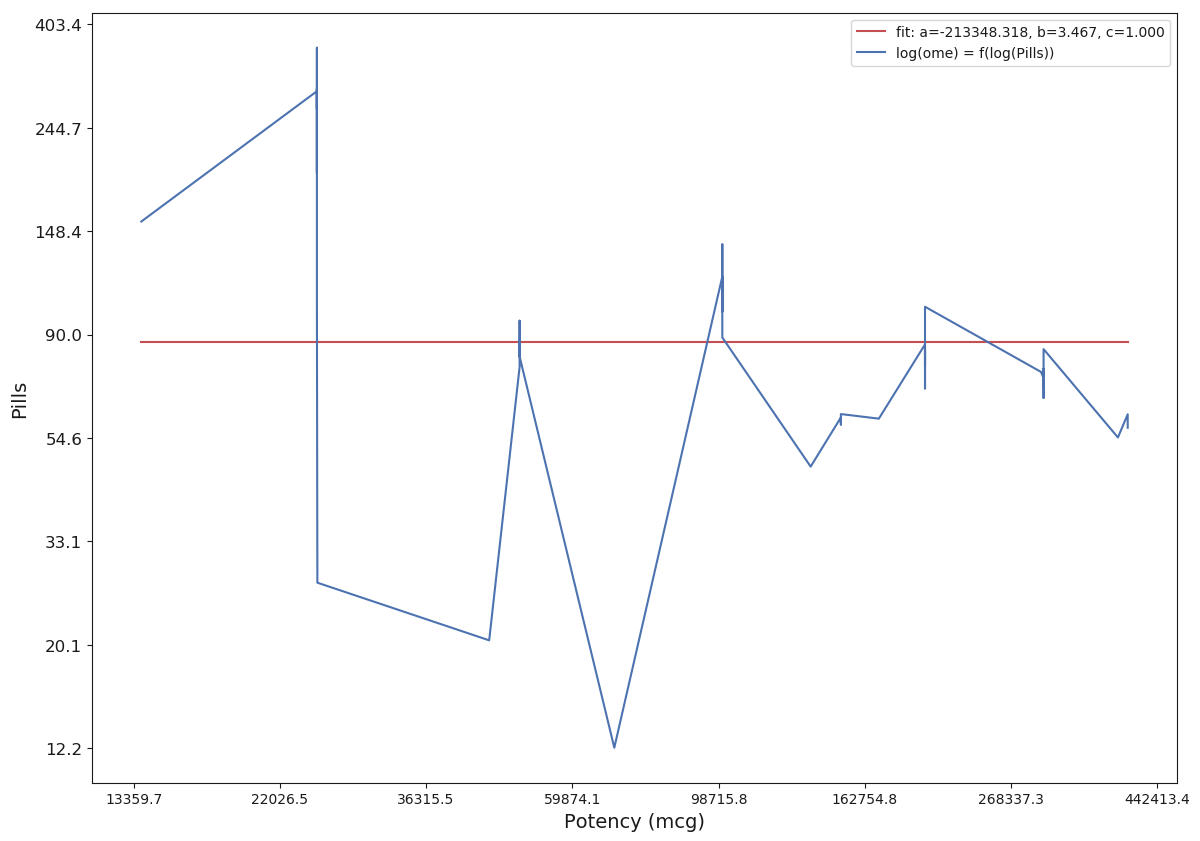

In [93]:
from scipy.optimize import curve_fit

def func(x, a, b , c):
    
    return (1.0/(1+a*np.exp(-b*x)) + b)
#     return a*np.exp(b*x)

y_val_new = [k for k in y_val]
x_val_new = [binpotency_val[k] for k in x_pos]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1], popt[2]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(ome) = f(log(Pills))')
plt.legend(loc='upper right')

ax.set_ylabel('Pills' , fontsize = 14)
ax.set_xlabel('Potency (mcg)',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

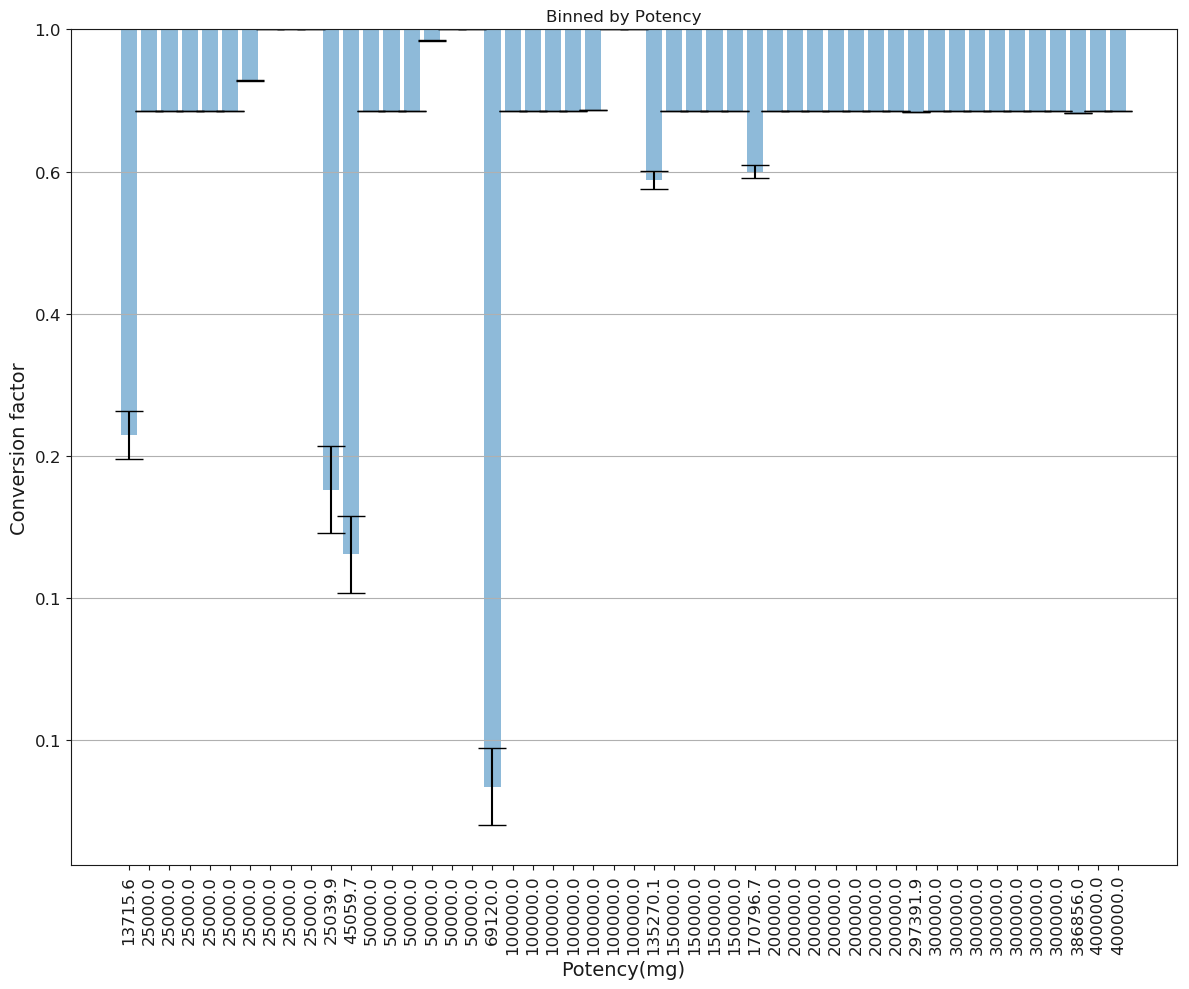

In [98]:
# Build the plot
fig, ax = plt.subplots(figsize=(12,10))
x_pos = np.arange(1,51,1)

x_labels = ['{:0.1f}'.format(np.exp(binpotency_val[k])) for k in x_pos]

y_val = [binned_mean_OME_potency[k] for k in x_pos]
err = [binned_var_OME_potency[k] for k in x_pos]
ax.bar(x_pos, y_val, yerr=err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Conversion factor' , fontsize = 14)
ax.set_xlabel('Potency(mg)',fontsize = 14)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation='90' , fontsize = 12)
ax.set_title('Binned by Potency')
ax.yaxis.grid(True)


ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


# Save the figure and show
plt.tight_layout()
plt.show()

[-772.35603456   78.82141332]
-0.6202431062269016


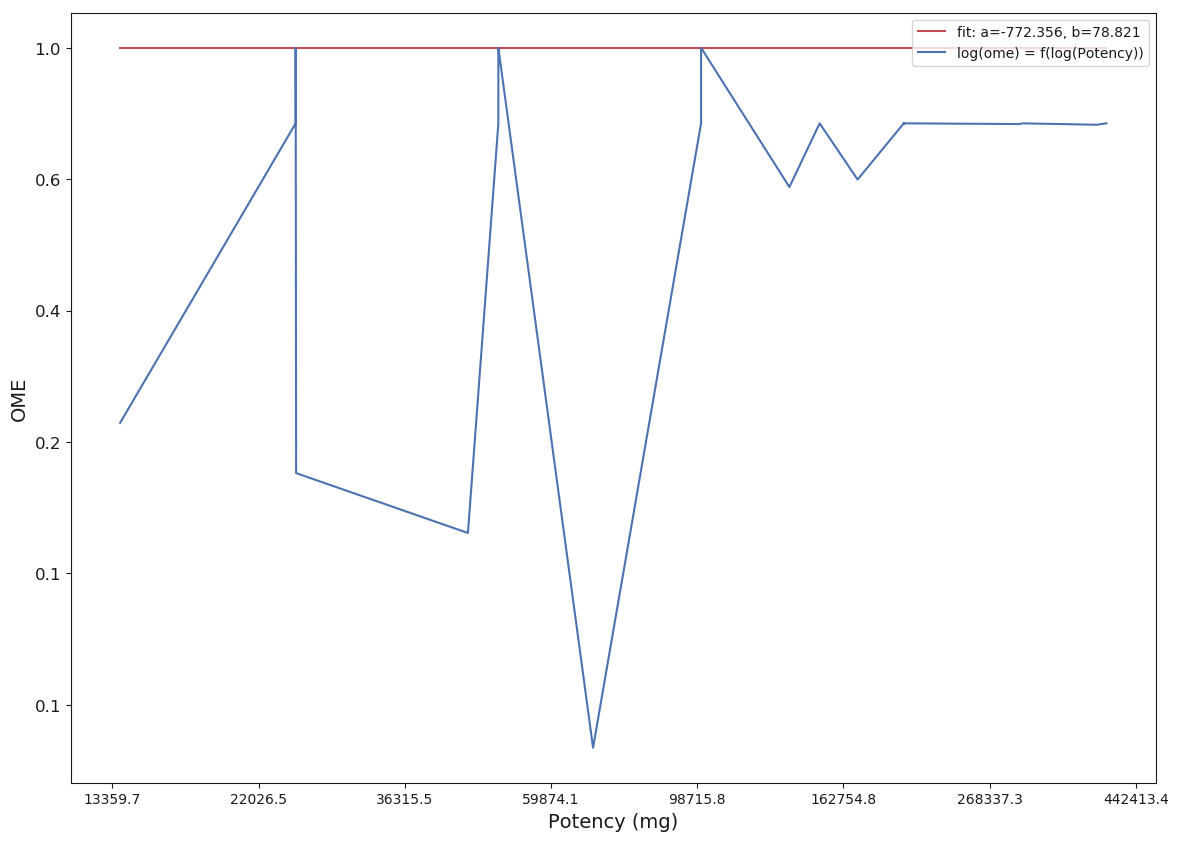

In [97]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*np.exp(-b*x)

y_val_new = [k for k in y_val]
x_val_new = [binpotency_val[k] for k in x_pos]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(ome) = f(log(Potency))')
plt.legend(loc='upper right')

ax.set_ylabel('OME' , fontsize = 14)
ax.set_xlabel('Potency (mg)',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

[-772.35603456   78.82141332]
-0.6202431062269016


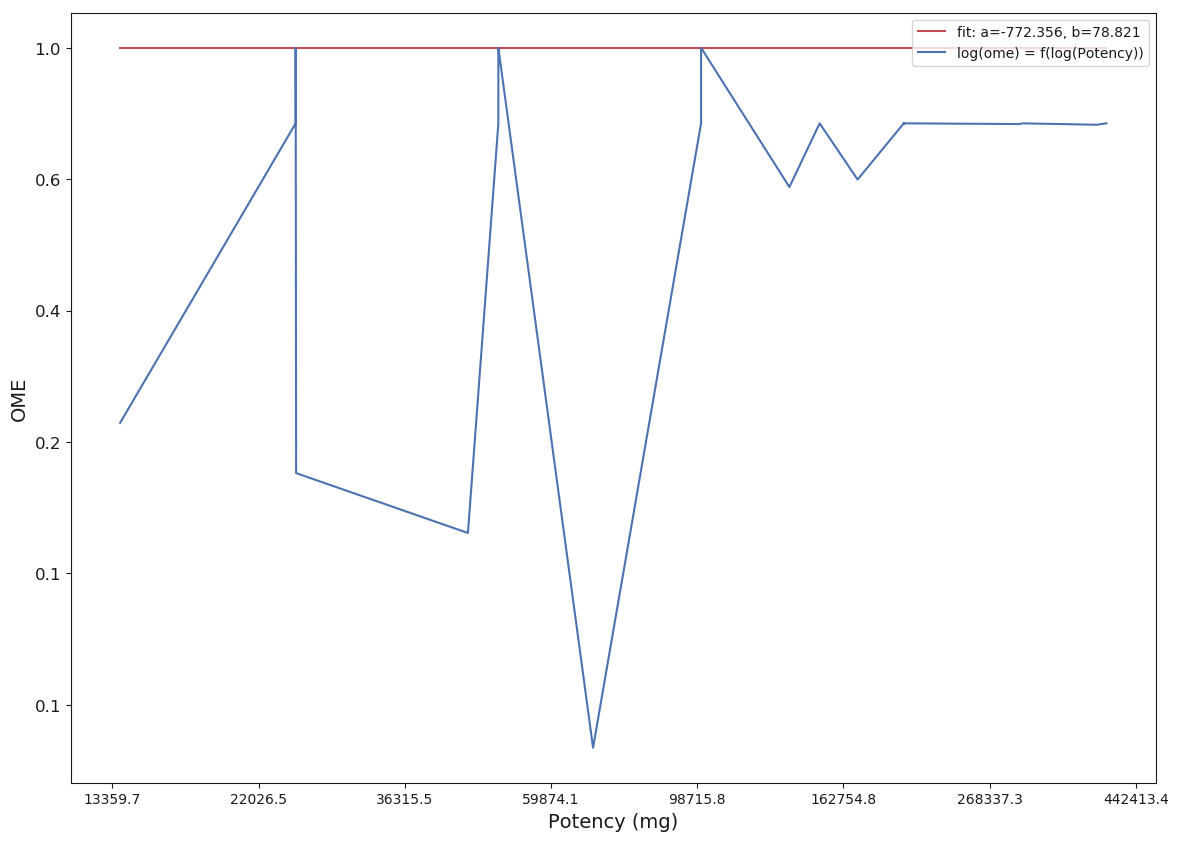

In [99]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*np.exp(-b*x)

y_val_new = [y_val[k] for k in range(len(x_pos)) if np.exp(binpotency_val[k+1]) >= 1.0]
x_val_new = [binpotency_val[k] for k in x_pos if np.exp(binpotency_val[k]) >= 1.0]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(ome) = f(log(Potency))')
plt.legend(loc='upper right')

ax.set_ylabel('OME' , fontsize = 14)
ax.set_xlabel('Potency (mg)',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

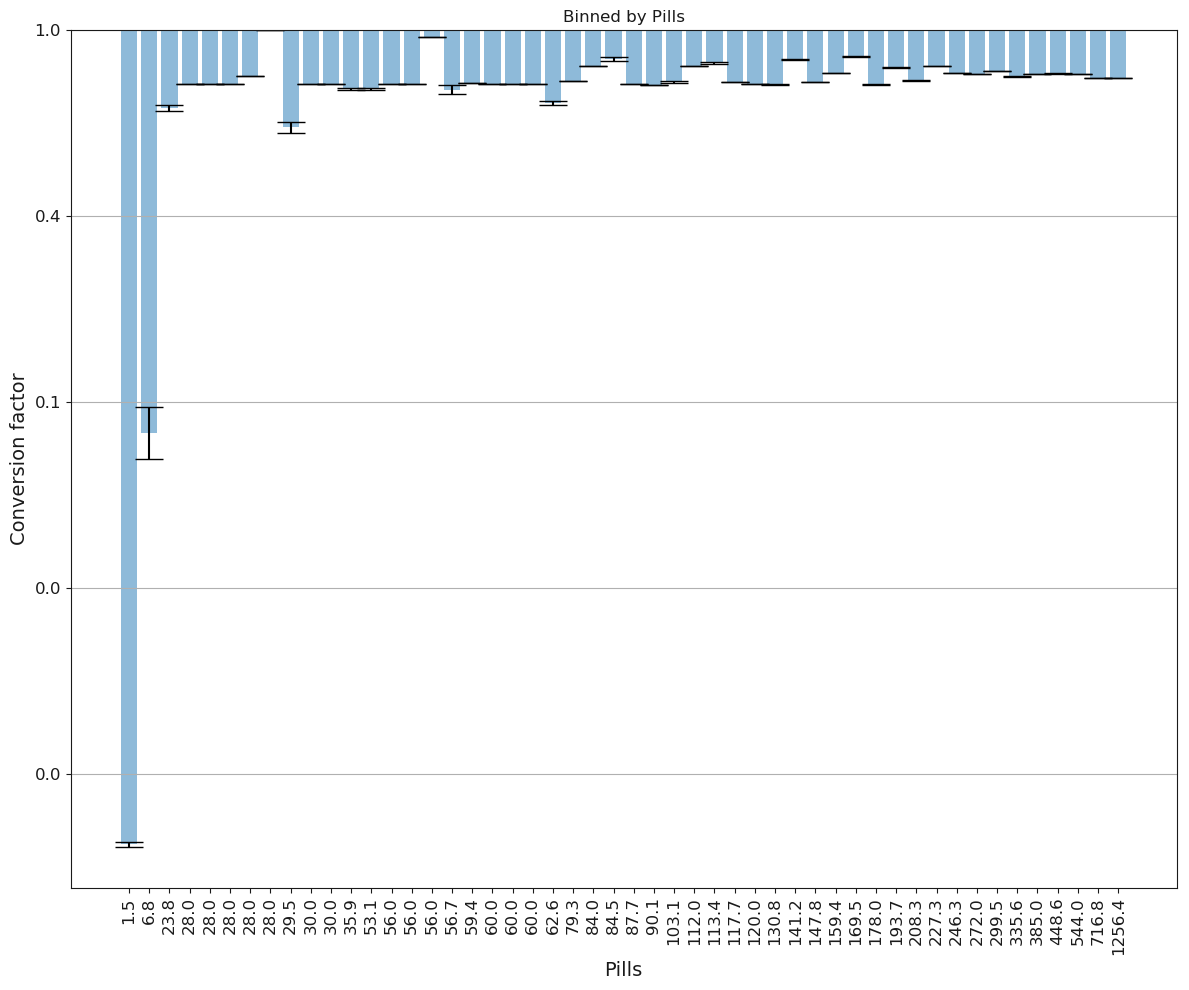

In [114]:
# Build the plot
fig, ax = plt.subplots(figsize=(12,10))
x_pos = np.arange(1,51,1)

x_labels = ['{:0.1f}'.format(np.exp(binpills_val[k])) for k in x_pos]

y_val = [binned_mean_OME_pills[k] for k in x_pos]
err = [binned_var_OME_pills[k] for k in x_pos]
ax.bar(x_pos, y_val, yerr=err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_title('Binned by Pills')
ax.set_ylabel('Conversion factor' , fontsize = 14)
ax.set_xlabel('Pills',fontsize = 14)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation='90' , fontsize = 12)


ax.yaxis.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


# Save the figure and show
plt.tight_layout()
plt.show()

[ 6.35576458  0.87823644 -0.12237375]
0.93091123376986


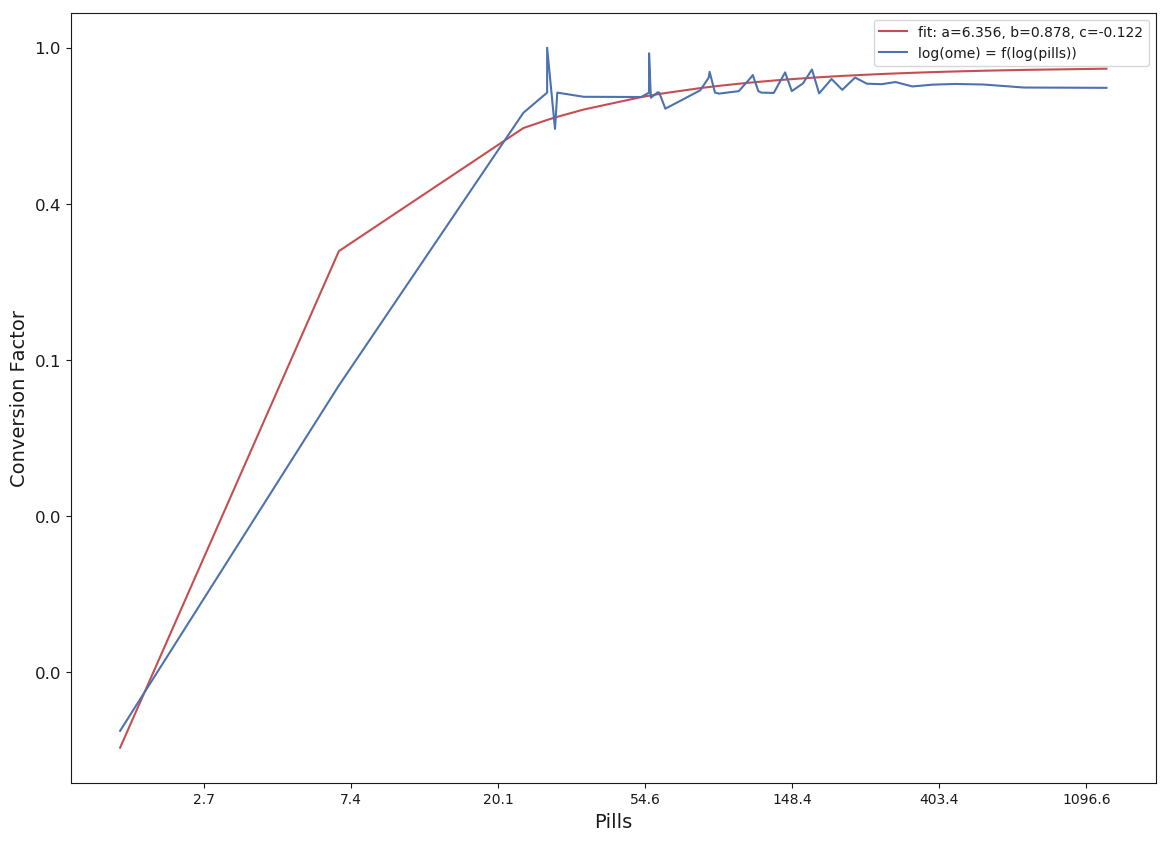

In [116]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return -a*np.exp(-b*x) + c

y_val_new = [k for k in y_val]
x_val_new = [binpills_val[k] for k in x_pos]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1], popt[2]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(ome) = f(log(pills))')
plt.legend(loc='upper right')
ax.set_ylabel('Conversion Factor' , fontsize = 14)
ax.set_xlabel('Pills',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

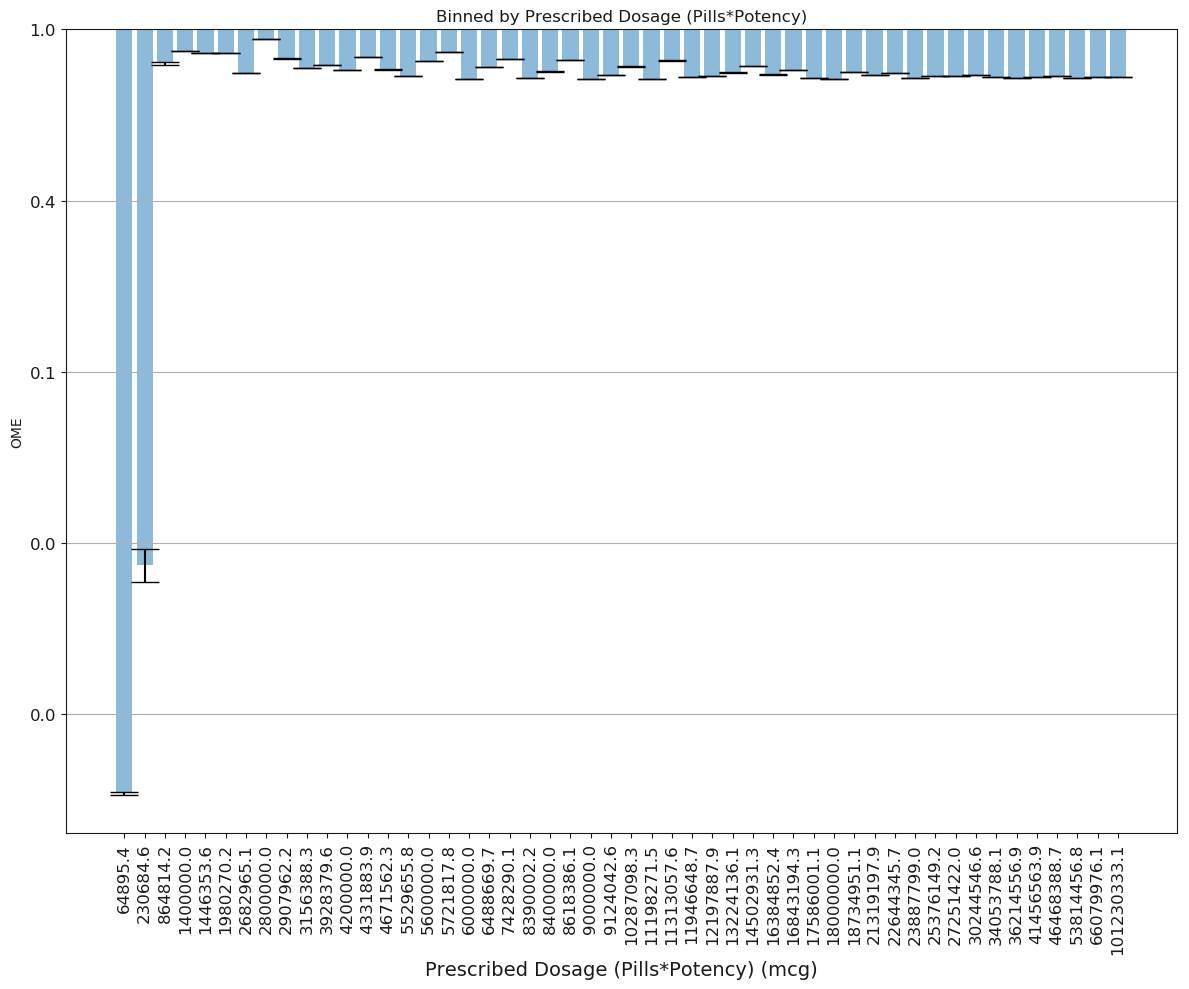

In [120]:
# Build the plot
fig, ax = plt.subplots(figsize=(12,10))
x_pos = np.arange(1,51,1)


x_labels = ['{:0.1f}'.format(np.exp(bindosage_val[k])) for k in x_pos]


y_val = [binned_mean_OME_dosage[k] for k in x_pos]
err = [binned_var_OME_dosage[k] for k in x_pos]
ax.bar(x_pos, y_val, yerr=err, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('OME')
ax.set_xlabel('Prescribed Dosage (Pills*Potency) (mcg)',fontsize = 14)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation='90' , fontsize = 12)

ax.set_title('Binned by Prescribed Dosage (Pills*Potency)')
ax.yaxis.grid(True)


ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)

# Save the figure and show
plt.tight_layout()
plt.show()

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


[ 2.78327370e+04  7.85837776e-01 -1.34060161e-01]
0.8845141086090343


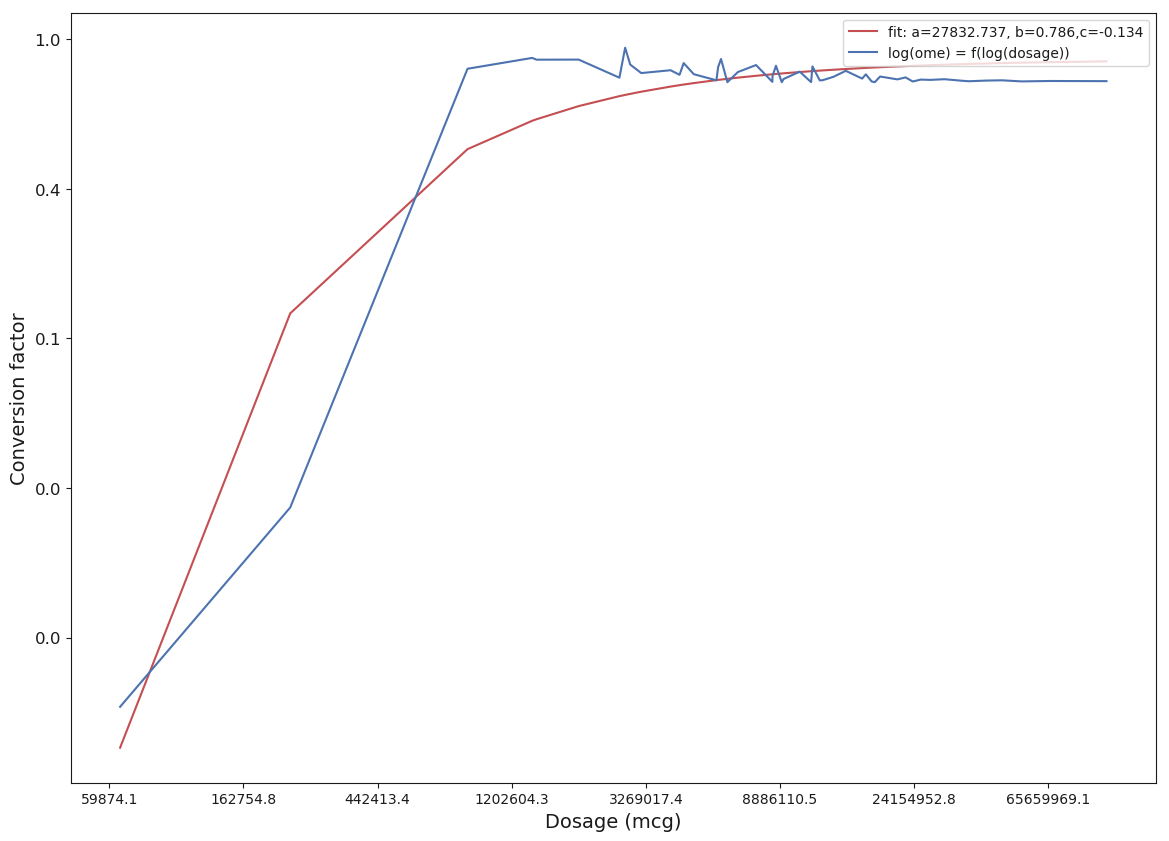

In [122]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return -a*np.exp(-b*x) + c

y_val_new = [k for k in y_val]
x_val_new = [bindosage_val[k] for k in x_pos]

popt, pcov = curve_fit(func,x_val_new, y_val_new)
print(popt)

evaluate = [func(k , popt[0], popt[1] , popt[2]) for k in x_val_new]

goodNessFit(np.array(y_val_new) , np.array(evaluate))

fig, ax = plt.subplots(figsize=(14,10))
plt.plot(x_val_new, evaluate, 'r-',  label='fit: a=%5.3f, b=%5.3f,c=%5.3f' % tuple(popt))
plt.plot(x_val_new, y_val_new , 'b-',  label='log(ome) = f(log(dosage))')
plt.legend(loc='upper right')
ax.set_ylabel('Conversion factor' , fontsize = 14)
ax.set_xlabel('Dosage (mcg)',fontsize = 14)

ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)


plt.show()

-2.220446049250313e-16


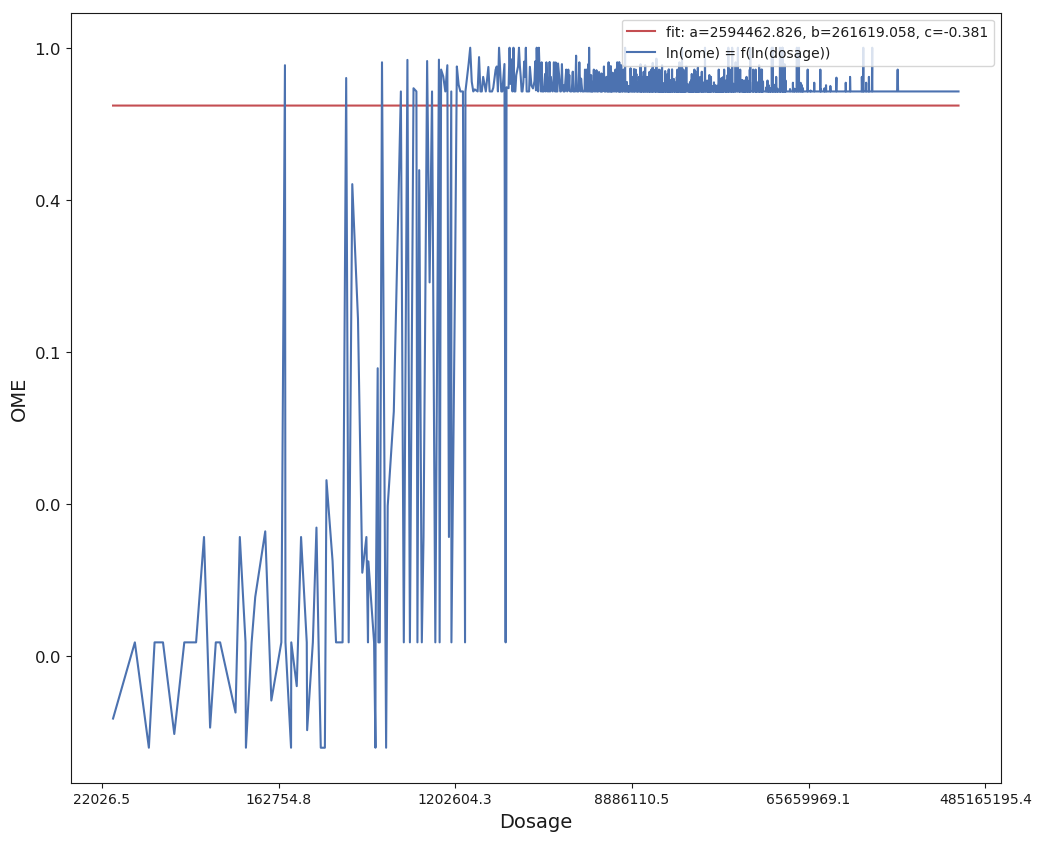

In [104]:
ome_df.sort_values(by='ln_dosage',inplace=True)

dosage_ome_dict = {'mean_ome':[] , 'ln_dosage':[]}
for name , group in ome_df.groupby('ln_dosage'):
    dosage_ome_dict['ln_dosage'].append(name)
    dosage_ome_dict['mean_ome'].append(np.mean(group['ln_ome']))
dosage_ome_df = pd.DataFrame.from_dict(dosage_ome_dict)

from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.exp(-b*x) + c

popt, pcov = curve_fit(func,dosage_ome_df['ln_dosage'], dosage_ome_df['mean_ome'])



goodNessFit(dosage_ome_df['mean_ome'], func(dosage_ome_df['ln_dosage'], *popt))

fig, ax = plt.subplots(figsize=(12,10))
plt.plot(dosage_ome_df['ln_dosage'], func(dosage_ome_df['ln_dosage'], *popt), 'r-',  label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(dosage_ome_df['ln_dosage'], dosage_ome_df['mean_ome'] , 'b-',  label='ln(ome) = f(ln(dosage))')
# ax.set_xticklabels([np.exp(k) for k in dosage_ome_df['ln_dosage'].tolist()])
plt.legend(loc='upper right')
ax.set_ylabel('OME' , fontsize = 14)
ax.set_xlabel('Dosage',fontsize = 14)
ax = plt.gca()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:0.1f}'.format(np.exp(x))))
plt.yticks(fontsize = 12)
plt.show()

In [281]:
# residual sum of squares
ss_res = np.sum((dosage_ome_df['mean_ome'] - func(dosage_ome_df['ln_dosage'],*popt)) ** 2)

# total sum of squares
ss_tot = np.sum((dosage_ome_df['mean_ome'] - np.mean(dosage_ome_df['mean_ome'])) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

0.8640729947236745


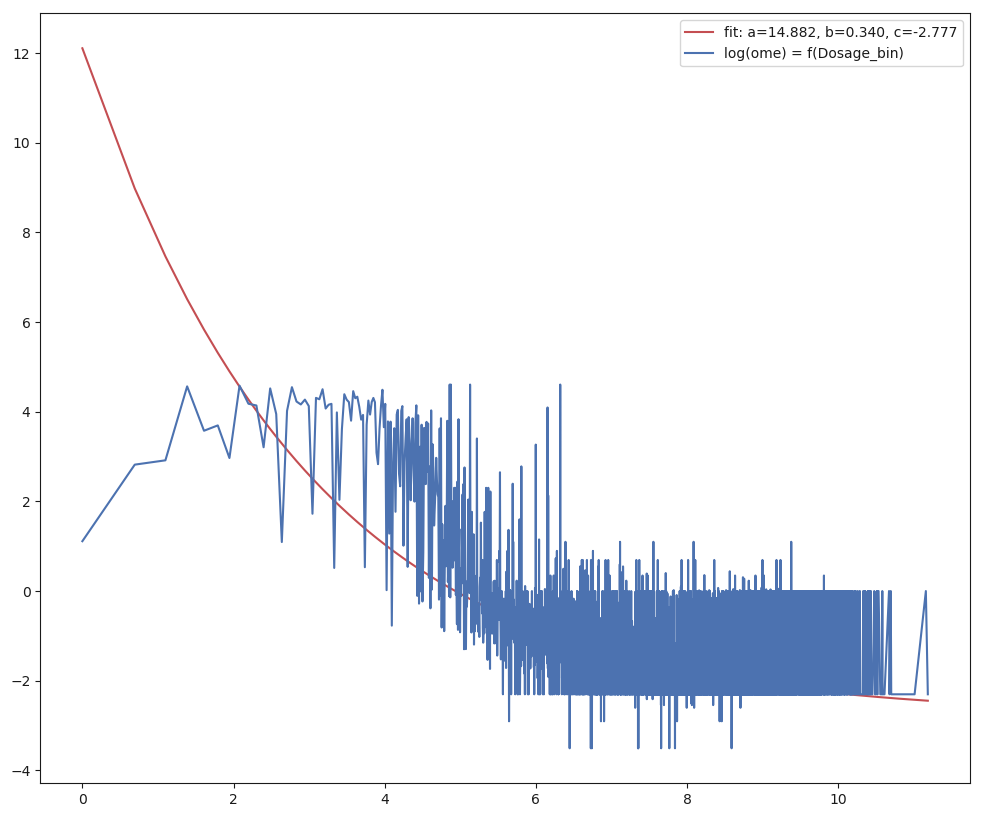

In [282]:
ome_df.sort_values(by='ln_pills',inplace=True)

dosage_ome_dict = {'mean_ome':[] , 'ln_pills':[]}
for name , group in ome_df.groupby('ln_pills'):
    dosage_ome_dict['ln_pills'].append(name)
    dosage_ome_dict['mean_ome'].append(np.mean(group['ln_ome']))
dosage_ome_df = pd.DataFrame.from_dict(dosage_ome_dict)

from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.exp(-b*x) + c

popt, pcov = curve_fit(func,dosage_ome_df['ln_pills'], dosage_ome_df['mean_ome'])

fig, ax = plt.subplots(figsize=(12,10))
plt.plot(dosage_ome_df['ln_pills'], func(dosage_ome_df['ln_pills'], *popt), 'r-',  label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(dosage_ome_df['ln_pills'], dosage_ome_df['mean_ome'] , 'b-',  label='log(ome) = f(Dosage_bin)')
plt.legend(loc='upper right')
plt.show()

In [283]:
# residual sum of squares
ss_res = np.sum((dosage_ome_df['mean_ome'] - func(dosage_ome_df['ln_pills'],*popt)) ** 2)

# total sum of squares
ss_tot = np.sum((dosage_ome_df['mean_ome'] - np.mean(dosage_ome_df['mean_ome'])) ** 2)

# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

0.38002286240117433


In [ ]:
def logit(x):
    return 1.0/(1.0 + 3*np.exp(-4*x))

In [ ]:
plt.plot(dosage_ome_df['ln_potency'] , logit(ln_potency)

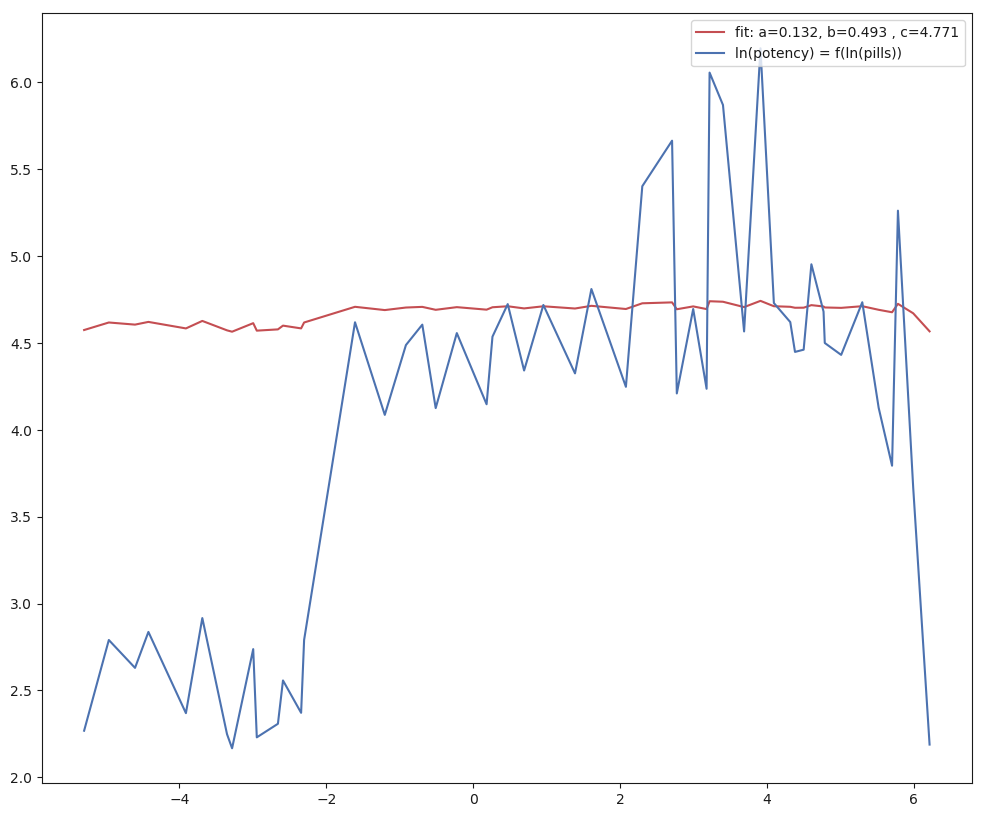

In [322]:
ome_df.sort_values(by='ln_potency',inplace=True)

dosage_ome_dict = {'mean_pills':[] , 'ln_potency':[]}
for name , group in ome_df.groupby('ln_potency'):
    dosage_ome_dict['ln_potency'].append(name)
    dosage_ome_dict['mean_pills'].append(np.mean(group['ln_pills']))
dosage_ome_df = pd.DataFrame.from_dict(dosage_ome_dict)

from scipy.optimize import curve_fit

def func(x, a, b ,c ):
    return c / (1.0 + a*np.exp(-b*x))

popt, pcov = curve_fit(func,dosage_ome_df['ln_potency'], dosage_ome_df['mean_pills'], bounds=(0 , [1., 3 , 100]))

fig, ax = plt.subplots(figsize=(12,10))
plt.plot(dosage_ome_df['ln_potency'], func(dosage_ome_df['mean_pills'], *popt), 'r-',  label='fit: a=%5.3f, b=%5.3f , c=%5.3f' % tuple(popt))
plt.plot(dosage_ome_df['ln_potency'], dosage_ome_df['mean_pills'] , 'b-',  label='ln(potency) = f(ln(pills))')
plt.legend(loc='upper right')
plt.show()

In [271]:
pcov

array([[1.66362995e-01, 2.87817011e-03, 1.04318547e-02],
       [2.87817011e-03, 6.89869565e-05, 3.21656529e-04],
       [1.04318547e-02, 3.21656529e-04, 1.77416017e-03]])

In [204]:
len(set(ome_df['3']))

436

In [232]:
pearsonr(ome_df['27'],ome_df['15'])

(-0.38456891755604494, 0.0)

In [233]:
ome_df_new = ome_df[ome_df['15']>0]

In [234]:
ome_df_new['27'] = 1/ome_df_new['24']

In [235]:
ome_df_new['28'] = ome_df_new['26']/ome_df_new['8']

Text(0.5,0,'ln(ome)')

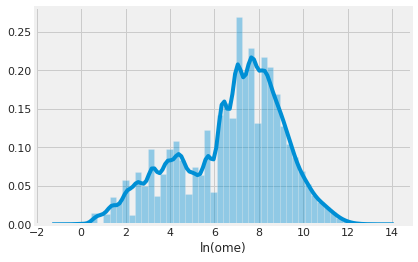

In [236]:
sns.distplot(np.log(ome_df_new['26']))
plt.xlabel('ln(ome)')

In [ ]:
sns.distplot(np.log(ome_df_new['27']))
plt.xlabel('ln(Quantity/Potency)')

In [ ]:
pearsonr(np.log(ome_df_new['28']) ,np.log(ome_df_new['15']))

In [ ]:
sub_df = ome_df_new[['24','26','27','15','4']]
sub_df.head()

In [ ]:
sub_df['26'] = np.log(sub_df['26'])
sub_df['27'] = np.log(sub_df['27'])
sub_df['24'] = np.log(sub_df['24'])

In [ ]:
Y_dims = ['26']
X_dims = ['24']

min_max_scaler = preprocessing.MinMaxScaler() 
Y_ome = min_max_scaler.fit_transform(np.array(sub_df[Y_dims].values,dtype=np.float32))
X_model = min_max_scaler.fit_transform(np.array(sub_df[X_dims].values,dtype=np.float32))

X_model = sm.add_constant(X_model)
print(X_model)
model = sm.OLS(Y_ome, X_model).fit()
model.summary()

In [ ]:
predicted = model.predict(X_model)

sns.regplot(sub_df['26'],predicted)
plt.xlabel('ln(ome)')
plt.ylabel('normalized predicted ln(ome)')

In [ ]:
sns.distplot(np.log(ome_df_new['8']))

In [ ]:
sns.distplot(np.log(ome_df_new['15']))

In [ ]:
drug_identifiers = opioids_ome['24'].unique()

In [ ]:
features = {'ome':[], 'mean_pills':[], 'sigma_pills':[],'mean_potency':[], 'sigma_potency' : [] , 'BNF':[] , 'mean_cost':[] ,'sigma_cost':[] , 'mean_dosage':[] , 'sigma_dosage':[] }
for name , group in opioids_ome.groupby('24'):
#     if bnf_ome_map[name] < 10:
    features['BNF'].append(name)
    features['mean_pills'].append(np.mean(group['8']))
    features['sigma_pills'].append(np.std(group['8']))
    features['mean_potency'].append(np.mean(group['15']))
#     features['min_potency'].append(np.min(group['15']))
#     features['max_potency'].append(np.max(group['15']))
    features['sigma_potency'].append(np.std(group['15']))
    features['mean_cost'].append(np.mean(group['7']))
    features['sigma_cost'].append(np.std(group['7']))
    features['mean_dosage'].append(np.mean(group['19']))
    features['sigma_dosage'].append(np.std(group['19']))
    features['ome'].append(bnf_ome_map[name])
features = pd.DataFrame.from_dict(features)

In [ ]:
features = features[features['mean_potency']!=0]

In [ ]:
features.head()

In [ ]:
features[features['mean_potency'] == 0.0]

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))         
corr = features.corr(method='pearson')
sns.heatmap(corr, annot=True , ax=ax ,cmap='Reds' )
ax.set_xticklabels(corr.columns, fontsize=15)
ax.set_yticklabels(corr.columns, fontsize=15)

In [ ]:
sns.regplot(features['ome'],features['mean_potency'])

In [ ]:
sns.distplot(np.log(features['mean_dosage']))
plt.xlabel("ln(mean_dosage)")

In [ ]:
sns.distplot(np.log(features['mean_cost']))
plt.xlabel("ln(mean_cost)")

In [ ]:
sns.distplot(np.log(features['mean_potency']))
plt.xlabel("ln(mean_potecy)")

In [ ]:
sns.distplot(np.log(features['ome']))
plt.xlabel("ln(ome)")

In [ ]:
features['ln_mean_potency'] = np.log(features['mean_potency'])
features['ln_mean_dosage'] = np.log(features['mean_dosage'])
features['ln_mean_cost'] = np.log(features['mean_potency'])
features['ln_mean_pills'] = np.log(features['mean_pills'])
features['ln_Impact'] = np.log(features['mean_potency']/features['mean_pills'])

In [ ]:
sns.distplot(features['ln_Impact'])

In [ ]:
# features_to_normalize = ['ln_mean_potency','ln_mean_dosage','ln_mean_cost']
# features[features_to_normalize] = features[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [ ]:
Y_dims = ['ome']
X_dims = ['ln_Impact']

min_max_scaler = preprocessing.MinMaxScaler() 
Y_ome = min_max_scaler.fit_transform(np.array(features[Y_dims].values,dtype=np.float32))
X_model = np.array(features[X_dims].values,dtype=np.float32)

X_model = sm.add_constant(X_model)
print(X_model)
model = sm.OLS(Y_ome, X_model).fit()
model.summary()

In [ ]:
predicted = model.predict(X_model)

sns.regplot(np.log(features['ome']),predicted)
plt.xlabel('ln(ome)')
plt.ylabel('normalized predicted ln(ome)')